In [13]:
# Copyright Tay Zhi Cong, year 2025

import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import math
import sys

#### Appendix: Method to obtain low pass filter tap coeffiecients

In [14]:
def get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, filter_length):
    beta = signal.kaiser_beta(stop_band_attenuation) # 1. calculate the kaiser beta
    # filter_length = math.ceil((f_sampling/f_transition) * (stop_band_attenuation-8)/14) # 2. estimate the filter length : N ~= f_sampling/ f_transition * (Attenuation (in dB) - 8) / 14
    filter_tap = signal.windows.kaiser(filter_length, beta=beta)
    h = np.sinc(2*f_minus_6db/f_sampling*np.linspace(-(filter_length - 1)/2,(filter_length - 1)/2,filter_length))*filter_tap
    h = h/sum(h)
    return h

def plot_filter_to_verify_spec(h, num_fft, f_sampling):
    freq_response = np.fft.fft(h, num_fft)
    freq = np.arange(0, len(freq_response), 1)/len(freq_response) * f_sampling

    plt.figure()
    ax = plt.subplot(1,2,1)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    ax.set_xlim(0, 50)
    ax.set_ylim(-100, 1)
    
    ax = plt.subplot(2,2,2)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 2, 12
    y_min, y_max = -6, 0.1
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    
    ax = plt.subplot(2,2,4)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 5, 7
    y_min, y_max = -100, -60
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


![6_1](img/6.1.png)

#### Equivalency theorem
The theorem states that the operations of down-conversion followed by a low-pass filter are totally equivalent to the operations of a band-pass filter followed by a down-conversion. We'll illustrate the theorem by showing that the following two is equivalent:

1. A real sinusoid at frequency 32.0kHz is present. Downconvert the sinusoid to 2kHz using a complex heterodyne. Then, low pass filter the sinusoid.
2. A real sinusoid at frequency 32.0kHz is present. Upconvert the low pass filter to be a complex band-pass filter centered at 30kHz. Band-pass filter the sinusoid, then downconvert the sinusoid to 2kHz.

#### 1a. Generate a real sinusoid at 32.0kHz.

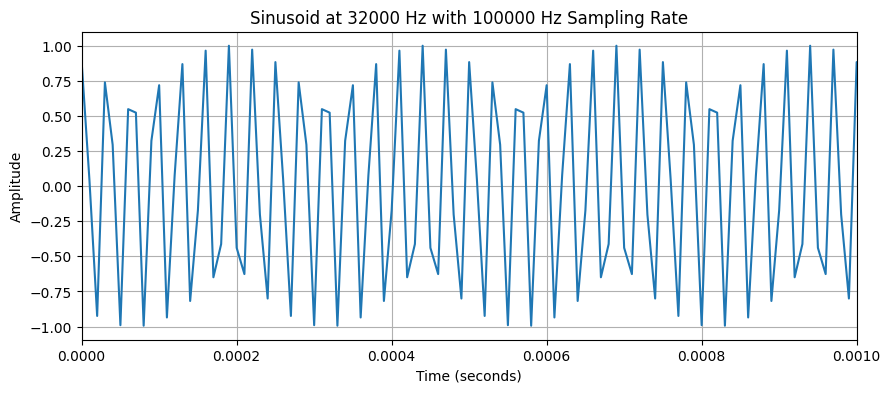

In [15]:
def generate_sinusoid(frequency, sample_rate, num_samples):
    # Calculate duration
    # num_samples = int(sample_rate * duration)
    duration = num_samples / sample_rate

    # Create the time axis
    t = np.linspace(0, duration, num_samples, endpoint=False)
    random_phase = np.random.uniform(0, 2 * np.pi)
    sinusoid = np.sin(2 * np.pi * frequency * t + random_phase)
    
    return t, sinusoid

# Define parameters for the sinusoid
signal_frequency = 32000  # Hz
sampling_rate = 100000   # Hz (must be at least twice the signal_frequency according to Nyquist-Shannon)
number_of_samples = 2000

# Generate the sinusoid
time_axis, signal_data = generate_sinusoid(signal_frequency, sampling_rate, number_of_samples)

# Plotting the generated sinusoid
plt.figure(figsize=(10, 4))
plt.plot(time_axis, signal_data)
plt.title(f'Sinusoid at {signal_frequency} Hz with {sampling_rate} Hz Sampling Rate')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.001)
plt.show()



#### 1b. Downconvert the sinusoid to 2kHz using a complex heterodyne. 

In [16]:
def generate_complex_sinusoid(frequency, sample_rate, num_samples, mode):
    duration = num_samples / sample_rate
    t = np.linspace(0, duration, num_samples, endpoint=False)

    # Generate the complex sinusoid
    if mode == "down":
        sinusoid = np.exp(-1j*2*np.pi*frequency*t)
    elif mode == "up":
        sinusoid = np.exp(1j*2*np.pi*frequency*t)

    return t, sinusoid

In [17]:
# Use a complex heterodyne centered at 30kHz to down-convert the input signal
t, complex_heterodyne = generate_complex_sinusoid(30000, sampling_rate, number_of_samples, "down")
downconverted_signal = signal_data * complex_heterodyne

#### 1c. Low pass filter the sinusoid. 

(-100.0, 1.0)

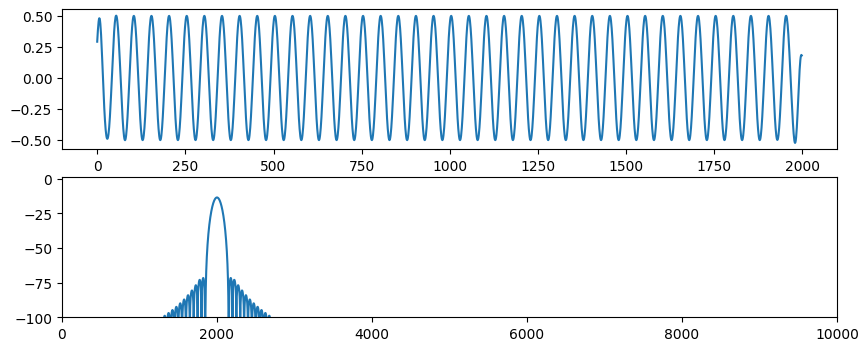

In [63]:
stop_band_attenuation = 60
f_sampling = 100
f_transition = 2
f_minus_6db = 5
low_pass_filter_length = 189

h = get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, low_pass_filter_length)

# present the down-converted data to the base-band low pass filter designed
output1 = np.convolve(downconverted_signal, h)

# discard extra samples
output1 = output1[94:]
output1 = output1[:-95]

plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.plot(np.real(output1))
plt.subplot(2,1,2)
ff = np.arange(0, 1, 1/(1024*1024))*100000
plt.plot(ff, 20*np.log10(abs(1/len(output1) * np.fft.fft(output1 * np.blackman(len(output1)), 1024*1024))))
plt.xlim(0, 10000)
plt.ylim(-100,1)

#### 2a. Reuse the real sinusoid at 32.0kHz from 1a.

#### 2b. Upconvert the low pass filter to be a complex band-pass filter centered at 30kHz. 

In [36]:
# up-convert the base-band low-pass filter to form a complex band centered filter centered at 30 kHz
t, cs189 = generate_complex_sinusoid(30000, sampling_rate, low_pass_filter_length, "up")
upconverted_base_band_low_pass_filter = h * cs189
#ff = np.arange(0, 1, 1/1024)*100000
#plt.plot(ff, 20*np.log10(abs(np.fft.fft(upconverted_base_band_low_pass_filter, 1024))))

#### 2c. Band-pass filter the sinusoid, then downconvert the sinusoid to 2kHz.

(-100.0, 1.0)

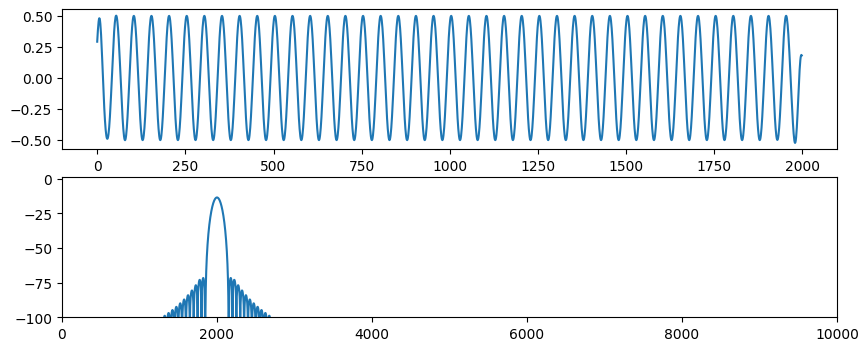

In [69]:
filtered_signal_data = np.convolve(signal_data, upconverted_base_band_low_pass_filter)
# discard extra samples here will not work, ie the following two lines will cause the dsp "magic" not working
# filtered_signal_data = filtered_signal_data[94:]
# filtered_signal_data = filtered_signal_data[:-95]

t, cs1999 = generate_complex_sinusoid(30000, sampling_rate, filtered_signal_data.shape[0], "down")
output2 = filtered_signal_data * cs1999

# discard extra samples here will work
output2 = output2[94:]
output2 = output2[:-95]

# ff = np.arange(0, 1, 1/(1024*1024))*100000
# plt.plot(ff, 20*np.log10(abs(np.fft.fft(output1, 1024*1024))))

plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.plot(np.real(output2))
plt.subplot(2,1,2)
ff = np.arange(0, 1, 1/(1024*1024))*100000
plt.plot(ff, 20*np.log10(abs(1/len(output2) * np.fft.fft(output2 * np.blackman(len(output2)), 1024*1024))))
plt.xlim(0, 10000)
plt.ylim(-100,1)
#plt.plot(output2-output1)

# downconvert_complex_output_downsampled = np.reshape(downconvert_complex_output, (219,10))
# window = np.hanning(len(downconvert_complex_output_downsampled[:,0]))
# plt.figure()
# plt.plot(np.imag(downconvert_complex_output_downsampled[:,0]))
# ff = np.arange(0, 1, 1/(1024*1024))*10000
# plt.plot(ff, 20*np.log10(abs(np.fft.fft(window*downconvert_complex_output_downsampled[:,9], 1024*1024))))

(-100.0, 1.0)

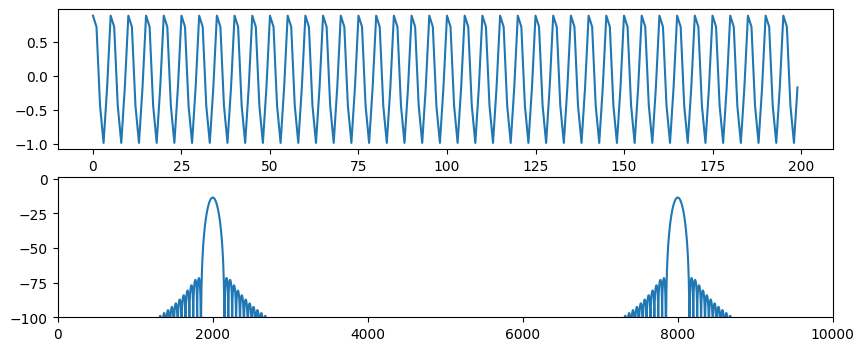

In [59]:
signal_data_downsampled = np.reshape(signal_data, (200,10))

plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.plot(np.real(signal_data_downsampled[:,0]))
plt.subplot(2,1,2)
ff = np.arange(0, 1, 1/(1024*1024))*100000/10
plt.plot(ff, 20*np.log10(abs(1/len(signal_data_downsampled[:,0]) * np.fft.fft(signal_data_downsampled[:,0] * np.hamming(len(signal_data_downsampled[:,0])), 1024*1024))))
plt.xlim(0, 10000)
plt.ylim(-100,1)